# Fine Tuning YOLOV3 To Detect Masks From Scratch

In this netbook we will fine tune yolov3 model to detect masks from scratch using tensorflow and keras.We will learn a lot, such as encoding and decoding data and netout and how to use yolo algorithm to prepare data using image segmentation into grids methode,and how to make the output of the model a list of arrays with different shapes(detect small and big objects) also we will learn how to use weights of a specifique class from yolov3 as a starting point.
I used Face Mask Detection dataset (https://www.kaggle.com/datasets/andrewmvd/face-mask-detection) and the accuracy was too good when trying the real time mask detection

If this Kernel helped you in any way, give it an upvote (such that I can increasy my online self-esteem...)$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 394.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b82eb8831436e50bb9db0c5f88bdd2a29bca9489950df173670e64da4231cfac
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.3
    Uninstalling idna

In [3]:
# This is Face Mask dataset from kaggle converted into yolo format with txt files using roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NY3PWalwsDPYmaOHhqlJ")
project = rf.workspace("abdelhakim-workspace").project("mask-detection-with-high-performcance")
dataset = project.version(4).download("darknet")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to mask-detection-with-high-performcance-4 in darknet:: 100%|██████████| 2936/2936 [00:00<00:00, 7278.10it/s]


In [4]:
train_path = '/kaggle/working/mask-detection-with-high-performcance-4/train'

In [41]:
from PIL import Image

def is_supported(x):
    try:
        byte_img = tf.io.read_file(x)
        img = tf.io.decode_jpeg(byte_img)
        return True
    except:
        return False

def remove_invalid_images(dataset):
    return dataset.filter((lambda x: tf.py_function(func=is_supported, inp=[x], Tout=tf.bool))) # logical_not is a fuction that returns the negation, In other words, if is_supported returns True, this lambda function will return False, and if is_supported returns False, this lambda function will return True.

def get_annotation_filename(image_filename):
    # Get the filename without the extension
    #"." correspond à un point,
    # "[^/.]" signifie n'importe quel caractère qui n'est ni un point ni un slash,
    # "+" signifie une ou plusieurs répétitions du caractère précédent,
    # "$" correspond à la fin de la chaîne de caractères.
    base_filename = tf.strings.regex_replace(image_filename, '\\.[^/.]+$', '')
    # Append the .txt extension to the filename
    annotation_filename = tf.strings.join([base_filename, '.txt'])
    return annotation_filename

In [42]:
images_paths = tf.data.Dataset.list_files(train_path + '/*.jpg', shuffle=False)
images_paths = remove_invalid_images(images_paths)

In [43]:
annotations_paths = images_paths.map(get_annotation_filename)

In [44]:
annotations = []
for file in annotations_paths:
    coords = []
    with open(file.numpy()) as f:
        lines = f.read()
        lines = lines.split('\n')
        lines = [l.split(' ') for l in lines]
        for n,line in enumerate(lines):
            number = []
            for i,l in enumerate(line):
                if lines[n][i]:
                    number.append(float(lines[n][i]))
            if number:
                coords.append(number)
    annotations.append(coords)

In [45]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.cast(tf.image.resize(img,[416,416]),tf.int32)
    img = tf.reshape(img,[416,416,3])
    return img

In [46]:
train_images = images_paths.map(load_image)

In [47]:
train_images = train_images.map(lambda x: x/255)

In [48]:
train_images

<MapDataset shapes: (416, 416, 3), types: tf.float64>

# Train data encoding

In [49]:
# inverse of sigmoid function
def _logit(x):
    x = np.clip(x, 1e-9, 1 - 1e-9)  # clip values to (0, 1) range to solve -inf problème
    return np.log(x / (1 - x))

In [50]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
nb_classes = 3

In [73]:
def encode_annotations(annotation, nb_classes, anchors, net_h, net_w):
    nb_bbox = 3
    shape = [(13, 13, nb_bbox, nb_classes+5), (26, 26 ,nb_bbox, nb_classes+5), (52, 52, nb_bbox, nb_classes+5)] # +5 for the bbox and objness
    train_netout = [np.ones(s)*1e-9 for s in shape] # we are making values 1e-9 that is a very small number because we will apply _logit function to elements ,so they should't be 0.
    for a in annotation:
        for number, n in enumerate(train_netout):
            grid_h, grid_w = n.shape[:2]
            x, y, w, h = a[1:]
            # here we have y and x that are normalized,so we are multiplying them by grid dims to make grid dims the units and know which col and row using int()
            i = int(x * grid_w) # row
            j = int(y * grid_h) # col
            for b in range(len(n[j][i])):
                # class value and objness
                if np.all(train_netout[number][j][i][b][4:] == 1e-9) : # if all array éléments are 1e-9, to know if we have updating the data in this bbox , if yes we will pass to the second bbox(we have 3 bboxes)  
                    train_netout[number][j][i][b][5+int(a[0])] = 1 # here we are adding a[0],to know wich class that has 1 (wich class is correct)
                    train_netout[number][j][i][b][4] = 1 
                # coords
                encoded_x = x * grid_w - j
                encoded_y = y * grid_h - i

                if np.all(train_netout[number][j][i][b][:4] == 1e-9):
                    encoded_w = np.log(w * net_w / anchors[number][2 * b + 0])
                    encoded_h = np.log(h * net_h / anchors[number][2 * b + 1])
                    train_netout[number][j][i][b][:4] = encoded_x, encoded_y, encoded_w, encoded_h
                    break
    # apply the _logit function to x,y,objness,classes to be then decoded using sigmoid function
    for i in range(len(train_netout)):
        grid_h, grid_w = train_netout[i].shape[:2]
        train_netout[i][..., :2]  = _logit(train_netout[i][..., :2])
        train_netout[i][..., 4:]  = _logit(train_netout[i][..., 4:]) 
        train_netout[i] = train_netout[i].reshape((1,grid_h, grid_w,np.multiply(train_netout[i].shape[2],train_netout[i].shape[3])))
    return train_netout

In [89]:
HEIGHT, WIDTH = 416,416
encoded_train = [encode_annotations(annotation, nb_classes, anchors, HEIGHT, WIDTH) for annotation in annotations]

In [90]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims
from keras.preprocessing.image import load_img, img_to_array
 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2] # number of grids in y,numbmer of grids in x
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) # -1 signifie les indexes qui sont restés(confience,class,...)
    nb_class = netout[0].shape[-1] - 5 # will take 85 -5  (-5 pour ne pas calculer confience,...)
    boxes = []
    # "..." mean selecting all the dims,like doing map function and apply sigmoid to the first 2 éléments from each array(netout[..., :2] contient les coordonnées x et y de la boîte englobante prédite pour chaque grille de l'image d'entrée. )
    netout[..., :2]  = _sigmoid(netout[..., :2])
    # like doing map function apply sigmoid to the éléments from index 4 for each array
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    # we are adding a new axe because they haven't the same dim,netout[..., 4][..., np.newaxis] has the objness(probability of presence for an object), and netout[..., 5:] has scores of classes and multiply them to get the real scores
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    # If netout[..., 5:] > obj_thresh it will returns 1 and then multiplies it by netout[..., 5:],else it will returns 0 and multiplies it by netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        # actually here i did not like the names of variables,but the row variable contains in which column in the row we are in, and col variable contains in which row we are in the column
        row = i / grid_w # we will then convert it to int ,so it will returns the same value grid_w times,and then it will returns 0 to repeat the same thing grid_h times
        col = i % grid_w # we will then convert it to int, so it will returns numbers from 0-12 and repeat it grid_h times
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness <= obj_thresh): continue # skip the iterate if the objectness is lower or equal to 0.6
            # first 4 elements are x, y, w, and h: x is representing the position (x) for the center of the bbox in the first col and first row (0,0)
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            # x is representing the relatif position of the center point in the bbox in term of the grid width(i don't mean the number of the grids in x) this mean we suppose that the image has 13 pixels and x is the position in the first grid. we are adding col to x to determine in which col the x is located,and then we are dividing by grid_w (number of grids in x) because the image will not necessary be 13 by 13 pixels, it can be anything so we normalize it to be compatible with all images(in correct_yolo_boxes function we will multiply it by the image width :here is 416)
            # to understand it more ,if x = 0.5 and col = 0,that mean x is exactely in the center of the grid that is in col, when we are adding col(0) to x ,the result be 0.5 ,and then we will divid it by 13(first grid_w) to get the value that will be compatible with all images, and then we can multiply it by 416(width of our image)
            # with another methode, if we multiply it by 416 that mean (col + x) / grid_w * 416 = 416/grid_w * col + 416/grid_w*x,here we are taking the width of each grid (416/grid_w) and multiply it by col to get the distance that precede the col where x is localted, and then add it to the width of the each grid multiply by x (position relative ini term of the width of each grid),when we multiply this mean that we will know what is the distance the procede the first point in the col and x, finaly we are adding this distances to get the real x .
            x = (col + x) / grid_w # center position, unit: image width
            # is the same of x but with y position
            y = (row + y) / grid_h # center position, unit: image height
            # anchors[1] the width is in index 0 ,anchors[1] is in index 2, and anchors[2] is in index 4, for that we used [2 * b + 0]
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            # [2 * b + 1] because the height is after 1 index from the width index
            h = anchors[2 * b + 1] * np.exp(h) / net_h #unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
        # we are calculation the offset(الازاحة) between the width of neural netword output and the new_image,and then dividing it by 2 because we want the image center point offset 
        # and then we are caculating the scale by dividing the new_w by the the width of the nn output
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w 
        # the same of x , but here we are calculating for y position
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        # calculation the coords by subtracting the offset from the coords of the point, and then divide the resulte by the scale to get the corect normalized value
        # finally we multiply the result by the image dim,to get the real coords for the image
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    # define an interval ([a;b])
	x1, x2 = interval_a 
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1: # if interval_b is left of the interval_a ,so there is no intersections:will return 0
			return 0
		else:
			return min(x2,x4) - x1 # we taked the minimun value from(x2,x4) to know which is the end of the intersection,and # we are substractint x1 from the result because it's biggert than x3
	else:
		if x2 < x3: # if interval_b is right of the interval_a ,so there is no intersections:will return 0
			 return 0
		else:
			return min(x2,x4) - x3 # we are substractint x3 from the result because it's biggert than x1

# Calculating the amount of similarity between two bboxes
def bbox_iou(box1, box2):
    # Calculation the somme of intersection between bboxes 
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax]) # somme of intersections in x axis for each bbox
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax]) # somme of intersections in y axis for each bbox
	intersect = intersect_w * intersect_h  # calculating the area of the intersection
    # calculation the width and the height of the bbox
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin 
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect # union(اتحاد) ,we are here calculation the union that is the somme of bboxes without the intersection
    # return the percentage of the intersection between the two bboxes
    # which is a value between 0 and 1, if it's 0 so there is no intersection,if it's 1 so there is a very high intersection
	return float(intersect) / union 
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)# will stock how many classes for the first bbox in the detection.(it's not important to use the first one,because we want just know how many classes the nn can prediction
    else:
        return
    for c in range(nb_class):
        # np.argsort is used to sort the indexes of the classes by their scores,
        sorted_indices = np.argsort([-box.classes[c] for box in boxes]) # we are make the score negatif to sort them from the biggest to the smalest
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue # if the score of the class is 0 ,it will skip the iteration
            for j in range(i+1, len(sorted_indices)): # will loop from i+1 to len(sorted_indices),we are adding one to i ,because we want to compare our bbox with the others bboxes
                index_j = sorted_indices[j] # the bbox that we will compare it with the current bbox
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh: # if the percentage of the intersection is biggest or equal to nms_thresh
                    boxes[index_j].classes[c] = 0 # we will give the bboxes that has a big similarity with this bbox 0.don't worry ,it will choose the one that has the biggest accuracy,because we sorted the scores from the biggest to the smalest

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i]) # %s will take v_labels[i], (%.3f) is used to make the scores float with 3 numbers after the point,() we will write it in the axis to separate them
        if v_labels[i] == 'mask':
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='green')
            # draw the box
            ax.add_patch(rect)
            pyplot.text(x1, y1, label, color='red')
        elif v_labels[i] == 'no mask':
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
            pyplot.text(x1, y1, label, color='red')
        else:
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='yellow')
            # draw the box
            ax.add_patch(rect)
            pyplot.text(x1, y1, label, color='yellow')

    # show the plot
    pyplot.show()

In [91]:
images_paths.batch(5).as_numpy_iterator().next()

array([b'/kaggle/working/mask-detection-with-high-performcance-4/train/2018-11-06t054310z-1334124005-rc1be15a8050-rtrmadp-3-people-sexiest-man_jpg.rf.2d3a619df33eba59207163243a0a9172.jpg',
       b'/kaggle/working/mask-detection-with-high-performcance-4/train/2018-11-06t054310z-1334124005-rc1be15a8050-rtrmadp-3-people-sexiest-man_jpg.rf.65c8e0c52055c3863de29d3e016f40d5.jpg',
       b'/kaggle/working/mask-detection-with-high-performcance-4/train/2018-11-06t054310z-1334124005-rc1be15a8050-rtrmadp-3-people-sexiest-man_jpg.rf.9012d43bc5c0fb264bec26aa154920fa.jpg',
       b'/kaggle/working/mask-detection-with-high-performcance-4/train/2018-11-06t054310z-1334124005-rc1be15a8050-rtrmadp-3-people-sexiest-man_jpg.rf.a52d4413fc9a579ef65fe5975ae2d441.jpg',
       b'/kaggle/working/mask-detection-with-high-performcance-4/train/Africa-2_png_jpg.rf.298574a67620f52a1b613a6b2a930243.jpg'],
      dtype=object)

no mask 99.99999979999998


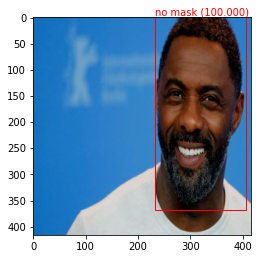

In [92]:
photo_filename = '/kaggle/working/mask-detection-with-high-performcance-4/train/2018-11-06t054310z-1334124005-rc1be15a8050-rtrmadp-3-people-sexiest-man_jpg.rf.65c8e0c52055c3863de29d3e016f40d5.jpg'
WIDTH, HEIGHT = 416,416
class_threshold = 0.3
# load picture with old dimensions
image, image_w, image_h = load_image_pixels(photo_filename, (WIDTH, HEIGHT))

# Predict image
yhat = encoded_train[2]
# Create boxes
boxes = list()
for i in range(3):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)# yhat[i][0] 0 because it has 4 dims 1,?,?,3 so we take 
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)

# suppress non-maximal boxes (make it small if you want to delete the duplicated bboxes)
do_nms(boxes, 0.1)

# define the labels (Filtered only the ones relevant for this task, which were used in pretraining the YOLOv3 model)
labels = ['mask weared incorrect',"mask","no mask"]

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)


# summarize what we found
for i in range(len(v_boxes)):

    print(v_labels[i], v_scores[i])

# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [93]:
# Convert encoded_train into a rectangular list(list of arrays with same shape), because tensorflow is not compatible with non rectangulars arrays

# 24 is ,(3 + 5)*3 first 3 is nb_classes,5 is coords and objness,and multipiled by 3 that is the number of bboxes for each grid
zeros_array = [[np.zeros(s) for s in [(1,52, 52,24), (1,52, 52 ,24), (1,52, 52, 24)]] for _ in range(len(encoded_train))] 
for a,annotation in enumerate(encoded_train):
    for e,e_t in enumerate(annotation):
        zeros_array[a][e][:,:e_t.shape[1],:e_t.shape[1],:] = e_t
encoded_train = zeros_array

In [94]:
y_train = tf.data.Dataset.from_tensor_slices(encoded_train)

In [95]:
train = tf.data.Dataset.zip((train_images, y_train))

In [96]:
# train = train.shuffle(2000)
train = train.batch(8)
train = train.prefetch(4)

# Fine-tuning-YOLOV3

In [97]:
from keras.models import load_model
from keras.layers import Conv2D
from keras.models import Model

In [98]:
yolo_model = load_model('/kaggle/input/yolov3-model/model.h5')

## Use personne weights beacause it's close to our class

In [99]:
# Get the weights of the outputs
weights1 = yolo_model.layers[-3].get_weights()
weights2 = yolo_model.layers[-2].get_weights()
weights3 = yolo_model.layers[-1].get_weights()

# Create new weights and biases arrays
new_weights1 = np.zeros([1, 1, 1024, 15+nb_classes*3]) #5*3+3*3 because we have 3 bboxes and 3 classes, bboxes has 4 values and we have also the objness 
new_weights2 = np.zeros([1, 1, 512, 15+nb_classes*3])
new_weights3 = np.zeros([1, 1, 256, 15+nb_classes*3])
new_bias1 = np.zeros([15+nb_classes*3])
new_bias2 = np.zeros([15+nb_classes*3])
new_bias3 = np.zeros([15+nb_classes*3])

# bboxes indexes
bbox1 = [0, 1, 2, 3, 4]
bbox2 = [85, 86, 87, 88, 89]
bbox3 = [170, 171, 172, 173, 174]

# classes probabilities
prob1 = [5 for _ in range(nb_classes)]
prob2 = [90 for _ in range(nb_classes)]
prob3 = [175 for _ in range(nb_classes)]

# Create a set of indices to keep
indices = bbox1+prob1+bbox2+prob2+bbox3+prob3 # we taked also the prob of the class,and we are writing the last value of each bbox 3 times because we have 3 classes

# Fill in the new weights and biases arrays
for i in range(len(indices)):
    new_weights1[:, :, :, i] = weights1[0][:, :, :, indices[i]]
    new_weights2[:, :, :, i] = weights2[0][:, :, :, indices[i]]
    new_weights3[:, :, :, i] = weights3[0][:, :, :, indices[i]]
    new_bias1[i] = weights1[1][indices[i]]
    new_bias2[i] = weights2[1][indices[i]]
    new_bias3[i] = weights3[1][indices[i]]

In [100]:
# Add new layers to adapt the model to your new data
new_output1 = Conv2D(15+nb_classes*3, (1,1), activation='linear', padding='same')(yolo_model.layers[-6].output) # connected to LeakyReLU (the layer that was connected to the previous ouput)
new_output2 = Conv2D(15+nb_classes*3, (1,1), activation='linear', padding='same')(yolo_model.layers[-5].output)
new_output3 = Conv2D(15+nb_classes*3, (1,1), activation='linear', padding='same')(yolo_model.layers[-4].output)

# Create a new model with ragged tensors as output
yolo_model = Model(inputs=yolo_model.input, outputs=[new_output1, new_output2, new_output3])

In [101]:
# Set the new weights and biases for the outputs
yolo_model.layers[-3].set_weights([new_weights1, new_bias1])
yolo_model.layers[-2].set_weights([new_weights2, new_bias2])
yolo_model.layers[-1].set_weights([new_weights3, new_bias3])

In [102]:
def list_mse(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse

In [103]:
class Mask(Model): 
    def __init__(self, model,  **kwargs): 
        super().__init__(**kwargs)
        self.model = model

    def compile(self, opt, loss, **kwargs):
        super().compile(**kwargs)
        self.lloss = loss
        self.opt = opt
    
    def train_step(self,batch, **kwargs):
        X, y = batch
        with tf.GradientTape() as tape:
            batch_loss = tf.constant(0.0)
            coords = self.model(X,training=True)
            for i in range(len(coords)):
                c = coords[i]
                if i == 0:
                    _, y = batch
                    y = tf.transpose(y, perm=[2,1, 0, 3, 4, 5])[0,0,:,:13,:13,:]
                elif i == 1:
                    _, y = batch
                    y = tf.transpose(y, perm=[2,1, 0, 3, 4, 5])[0,1,:,:26,:26,:]
                else:
                    _, y = batch
                    y = tf.transpose(y, perm=[2,1, 0, 3, 4, 5])[0,2,:,:52,:52,:]
                batch_loss += self.lloss(tf.cast(y,tf.float32),tf.cast(c,tf.float32))   
            grad = tape.gradient(batch_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"regress_loss":batch_loss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        batch_loss = tf.constant(0.0)
        coords = self.model(X,training=False)
        for i in range(len(coords)):
            c = coords[i]
            if i == 0:
                _, y = batch
                y = tf.transpose(y, perm=[2,1, 0, 3, 4, 5])[0,0,:,:13,:13,:]
            elif i == 1:
                _, y = batch
                y = tf.transpose(y, perm=[2,1, 0, 3, 4, 5])[0,1,:,:26,:26,:]
            else:
                _, y = batch
                y = tf.transpose(y, perm=[2,1, 0, 3, 4, 5])[0,2,:,:52,:52,:]
            batch_loss += self.lloss(tf.cast(y,tf.float32),tf.cast(c,tf.float32))   
        return {"regress_loss":batch_loss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [104]:
model = Mask(yolo_model)

In [105]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(Adam(learning_rate=1e-3),list_mse)
model.fit(train, epochs=20)

Epoch 1/20
     14/Unknown - 309s 22s/step - regress_loss: 500.8358

In [ ]:
model.compile(Adam(learning_rate=1e-4),list_mse)
model.fit(train, epochs=70)

In [ ]:
model.compile(Adam(learning_rate=1e-5),list_mse)
model.fit(train, epochs=10)

In [ ]:
yolo_model.save('mask_model.h5')

In [ ]:
import os
os.chdir(r'/kaggle/working')

!tar -czf /kaggle/working/mask_model.h5

from IPython.display import FileLink

FileLink(r'mask_model.h5')

## Real Time Mask Detection

In [ ]:
import numpy as np
import cv2
from keras.models import load_model
from keras.layers import Conv2D
from keras.models import Model
from tensorflow import lite as tflite

# output_details = interpreter.get_output_details()
yolo_model = load_model('mask_model.h5')

anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# in this code i changed x = (col + x) / grid_w to y = (row + x) / grid_w, and also in y , because because row is in x
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img, img_to_array
 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
#     netout = netout.numpy()
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0


def load_image_pixels(image, shape):
    height, width, _ = image.shape
    # load the image with the required size
    image = cv2.resize(image, shape)
    # convert to numpy array
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = image[np.newaxis, ...]
    return image, width, height

 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(image, v_boxes, v_labels, v_scores):
    # draw each box and label on the image
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        label = v_labels[i]
        score = v_scores[i]
        if label == 'mask'
            # draw the box
            cv2.rectangle(image, (box.xmin, box.ymin), (box.xmax, box.ymax), (0, 255, 0), 1)
            # draw the label and score
            text = f"{label} ({score:.3f})"
            cv2.putText(image, text, (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
        elif label = = 'no mask'
            # draw the box
            cv2.rectangle(image, (box.xmin, box.ymin), (box.xmax, box.ymax), (255, 0, 0), 1)
            # draw the label and score
            text = f"{label} ({score:.3f})"
            cv2.putText(image, text, (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
        else:
            # draw the box
            cv2.rectangle(image, (box.xmin, box.ymin), (box.xmax, box.ymax), (255, 255, 0), 1)
            # draw the label and score
            text = f"{label} ({score:.3f})"
            cv2.putText(image, text, (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 0), 1)
        

cap = cv2.VideoCapture(0)


while True:
    ret, frame = cap.read()          # read from camera
    WIDTH, HEIGHT = 416,416
    class_threshold = 0.6
    # load picture with old dimensions
    image, image_w, image_h = load_image_pixels(frame, (WIDTH, HEIGHT))
    
    yhat = yolo_model.predict(image)

    # Create boxes
    boxes = list()
    for i in range(3):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)# yhat[i][0] 0 because it has 4 dims 1,?,?,3 so we take 
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)

    # suppress non-maximal boxes
    do_nms(boxes, 0.1)

    # define the labels (Filtered only the ones relevant for this task, which were used in pretraining the YOLOv3 model)
    labels = ['mask weared incorrect',"mask","no mask"]

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)


    # summarize what we found
    for i in range(len(v_boxes)):

        print(v_labels[i], v_scores[i])

    # draw what we found
    draw_boxes(frame, v_boxes, v_labels, v_scores)

    cv2.imshow('frame',frame)         # show image
    if cv2.waitKey(10) == ord('q'):  # wait a bit, and see keyboard press
        break                        # if q pressed, quit

# release things before quiting
cap.release()
cv2.destroyAllWindows()